In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import datetime

In [2]:
data = pd.read_csv('dataset/SamsumgStock.KS.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
723,2020-09-09,58200,59300,57800,58400,58400.0,30597399
724,2020-09-10,59900,60000,59100,59200,59200.0,29923293
725,2020-09-11,59300,59400,58200,59000,59000.0,16017098
726,2020-09-14,60200,60800,59900,60400,60400.0,20648281
727,2020-09-15,60900,61000,60500,61000,61000.0,17787753


## Compute Mid Price

In [22]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2
len(mid_prices)

728

## Create Windows

Window: 50  
최근 50일 데이터를 보고 다음을 예측한다.

In [23]:
seq_len = 100
sequence_length = seq_len + 5

result = []

for index in range(len(mid_prices) - sequence_length + 1):
    result.append(mid_prices[index: index + sequence_length]) # slicing 60개

## Normalize Data

모델이 잘 예측하게 함. 

### How?

(맨 처음 값 - 해당 값) - 1 -> -1 해주는 이유는 처음 값을 0 으로 만들기 위함

In [24]:
normalized_data = []

for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)
result.shape

(624, 105)

In [25]:
# split train and test data

train = result[:-10, :]
np.random.shuffle(train)

row = int(round(train.shape[0] * 0.9))
x_train = train[:row, :100]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:row, 100:]

x_valid = train[row:, :100]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = train[row:, 100:]

x_test = result[-10:, :100]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[-10:, 100:]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(553, 100, 1) (553, 5)
(61, 100, 1) (61, 5)
(10, 100, 1) (10, 5)


 ## Build a Model

In [7]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(100, 1)))

model.add(LSTM(150, return_sequences=False))

model.add(Dense(5, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense (Dense)                (None, 5)                 755       
Total params: 192,155
Trainable params: 192,155
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filename = 'tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor='val_loss', patience=25)

## Training

In [31]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=20, epochs=1, 
          callbacks=[checkpoint, earlystopping])

28/28 [==============================] - ETA: 0s - loss: 2.7551e-04 - accuracy: 0.5009
Epoch 00001: val_loss did not improve from 0.00029
28/28 [==============================] - 2s 64ms/step - loss: 2.7551e-04 - accuracy: 0.5009 - val_loss: 4.0450e-04 - val_accuracy: 0.4426


## 모델 평가

In [32]:
scores = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 832us/step - loss: 8.7417e-04 - accuracy: 0.7000


In [33]:
scores # loss 와 metrics 를 담고있다.

[0.0008741699275560677, 0.699999988079071]

In [34]:
loss, accuracy = scores
print(f'loss: {loss:.4f}, accuracy: {accuracy*100:.2f}%')

loss: 0.0009, accuracy: 70.00%


## Prediction

In [35]:
pred = model.predict(x_test)

# pred / y_test -> 2차원 이되, 일렬 데이터로 변경..
pred = pred.reshape(-1, 1)
y_test_ = y_test.reshape(-1, 1)

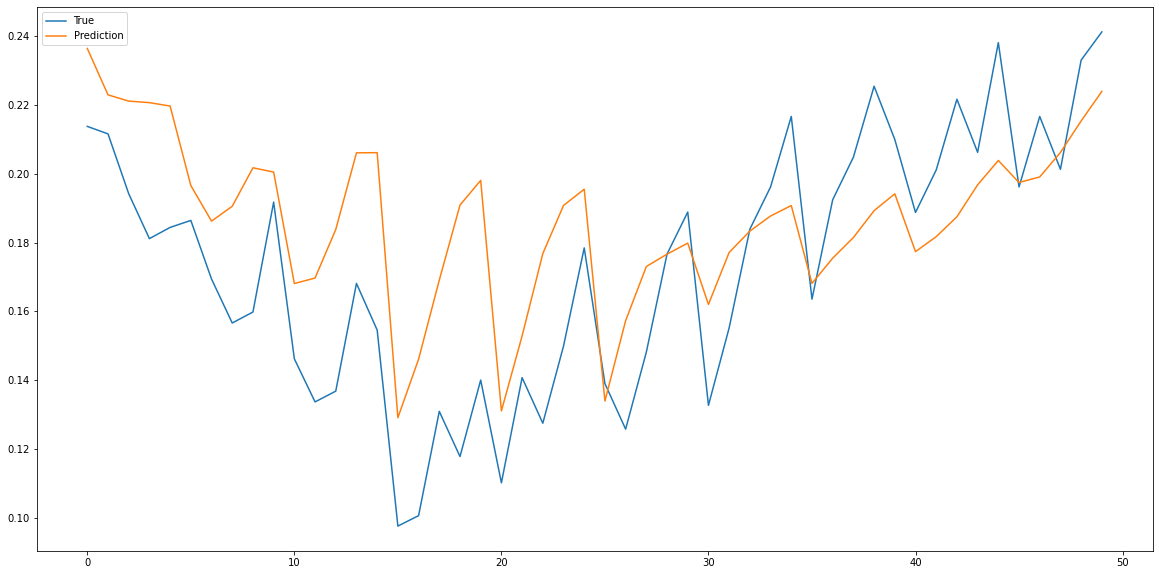

In [36]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test_, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

## 100 -> 5 Val loss = 0.0007 Epoch = 300 accuracy = 70%

In [16]:
ax.legend?